**Machine Learning for CV - Project**

In [1]:
# Install torch https://pytorch.org/get-started/locally/

%pip install numpy kagglehub matplotlib opencv-python --quiet
%pip install segmentation-models-pytorch --quiet
%pip install -U albumentations --quiet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


*Import libraries*

In [2]:
import os
import csv
import cv2
import kagglehub
import numpy as np

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import albumentations as A

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

/home/mike/DeVinci/Machine_Learning_for_CV/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Semantic Segmentation of Underwater Imagery

Dataset: https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim

In [3]:
path = kagglehub.dataset_download("ashish2001/semantic-segmentation-of-underwater-imagery-suim")
print("Path to dataset files:", path)

Path to dataset files: /home/mike/.cache/kagglehub/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim/versions/2


### Data preprocessing

In [4]:
# Mapping categories in TEST/masks
category_colors = {
    "Saliency": [0, 0, 0],  # Background (waterbody) (Called also BW)
    "HD": [0, 0, 255],      # Human divers
    "PF": [0, 255, 0],      # Aquatic plants and sea-grass
    "WR": [0, 255, 255],    # Wrecks and ruins
    "RO": [255, 0, 0],      # Robots (AUVs/ROVs/instruments)
    "RI": [255, 0, 255],    # Reefs and invertebrates
    "FV": [255, 255, 0],    # Fish and vertebrates
    "SR": [255, 255, 255],  # Sea-floor and rocks
}

CLASSES = list(category_colors.keys())
color_to_class = {tuple(value): idx for idx, (_, value) in enumerate(category_colors.items())}
idx_to_class = {idx: class_name for idx, class_name in enumerate(CLASSES)}

In [5]:
def convert_rgb_to_class(mask, color_to_class):
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.int64)
    
    for color, class_idx in color_to_class.items():
        color = np.array(color, dtype=np.uint8)
        matches = np.all(mask == color, axis=-1)  # Find pixels matching this color
        class_mask[matches] = class_idx
    
    return class_mask

### Custom Dataset class

The dataset organizes image and mask pairs, with separate logic for handling training/validation and testing data.

When initializing the dataset, the class takes in several parameters: the dataset's `base_path`, whether it's for `train` or test, and optional `augmentation` and `preprocessing` functions. Depending on whether you're training/validating or testing, the class sets the image and mask directories appropriately. 

For the test dataset, the masks might be organized within subfolders representing classes, while training/validation masks are assumed to reside flat within a single directory.

In the `__getitem__` method, the class reads an image using OpenCV, converts it to RGB format, and loads the corresponding mask. The mask is transformed into a class-index format and subsequently converted into a one-hot encoded array. Augmentation and preprocessing steps are applied if provided.

If it is the testing dataset, the class offers an additional method, `get_mask_by_class`, which retrieves a mask corresponding to a specific class by accessing the subfolder structure. This method enables focused evaluation for individual classes.

In [6]:
class CustomDataset(BaseDataset):
    def __init__(self, base_path, train=True, augmentation=None, preprocessing=None):        
        self.base_path = base_path
        self.train = train
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        if train:
            # Training/validation data
            self.images_dir = os.path.join(base_path, "train_val", "images")
            self.masks_dir = os.path.join(base_path, "train_val", "masks")
        else:
            # Test data
            self.images_dir = os.path.join(base_path, "TEST", "images")
            self.masks_dir = os.path.join(base_path, "TEST", "masks")
        
        self.image_files = os.listdir(self.images_dir)
        self.class_values = [key for key,_ in enumerate(CLASSES)]

        # Get all the mask files from the main masks folder and its subdirectories (for test set)
        if train:
            self.mask_files = os.listdir(self.masks_dir)
            self.subfolders = None
        else:
            self.mask_files = [
                filename for filename in os.listdir(self.masks_dir)
                if os.path.isfile(os.path.join(self.masks_dir, filename))
            ]
            self.subfolders = [
                filename for filename in os.listdir(self.masks_dir)
                if os.path.isdir(os.path.join(self.masks_dir, filename))
            ]

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image with cv2
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        mask_name = self.image_files[idx].split(".")[0]+".bmp"

        # Prepare mask
        mask_path = os.path.join(self.masks_dir, mask_name)
        rgb_mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        rgb_mask = cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Convert RGB mask to class index mask
        mask = convert_rgb_to_class(rgb_mask, color_to_class)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
                       
        return image, mask
    
    def get_mask_by_class(self, item_idx, class_name):
        if self.train == True:
            return None
        else:
            mask_name = self.image_files[item_idx].split(".")[0]+".bmp"
            mask_path = os.path.join(self.masks_dir, class_name, mask_name)
            rgb_mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            rgb_mask = cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB) 
            return rgb_mask

In [7]:
def visualize(image, mask, alpha=0.5):
    """
    Visualize the original image and the original image with the segmentation mask overlaid.
    
    Parameters:
    - image: Original image (H, W, 3).
    - mask: Segmentation mask, either multi-class (H, W, num_classes) or RGB (H, W, 3).
    - alpha: Transparency level for the mask overlay.
    """
    # Normalize the image if necessary
    if image.max() > 1:
        image = image / 255.0

    # Determine if the mask is multi-class or RGB
    if mask.ndim == 3 and mask.shape[-1] > 3:  # Multi-class segmentation
        # Define a color map with unique colors for each class
        colors = plt.get_cmap('tab20', mask.shape[2])
        cmap = ListedColormap([colors(i) for i in range(mask.shape[2])])

        # Get the class with the highest score at each pixel
        combined_mask = np.argmax(mask, axis=2)

        # Create a color image of the mask for overlay
        color_mask = cmap(combined_mask / combined_mask.max())[:, :, :3]  # Remove alpha channel if present
    elif mask.ndim == 3 and mask.shape[-1] == 3:  # RGB image mask
        # Normalize RGB mask if necessary
        if mask.max() > 1:
            mask = mask / 255.0
        color_mask = mask
    else:
        raise ValueError("Mask must have shape (H, W, num_classes) or (H, W, 3).")

    # Ensure the image has the shape (height, width, channels)
    if image.shape[0] == 3:  # If shape is (3, height, width)
        image = np.transpose(image, (1, 2, 0))  # Transpose to (height, width, 3)

    # Overlay the mask on the original image
    overlayed_image = (1 - alpha) * image + alpha * color_mask

    # Clip values to ensure they stay within [0, 1]
    overlayed_image = np.clip(overlayed_image, 0, 1)

    # Plot original and overlayed images side by side
    plt.figure(figsize=(12, 6))

    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Show the image with segmentation overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image)
    plt.title("Image with Segmentation Overlay")
    plt.axis('off')

    plt.show()

In [8]:
def create_folder_if_not_exist(folder):
  if not os.path.exists(folder):
      os.makedirs(folder)
      
def write_csv(filename, headers, values, multi_rows=False):
  with open(f"{filename}.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        if multi_rows == True:
          for v in values:
            writer.writerow(v)
        else:
          writer.writerow(values)

## 3. Methodology



### Data Augmentation and Preprocessing

#### Checking and Padding Images
The code defines two functions, `check_pad` and `pad_to_multiple`, that ensure images' dimensions (height and width) are divisible by a specified multiple (default is 32). This is essential for neural network models, as many architectures (e.g., for segmentation) require the input size to be compatible with the model's stride. If an image's height or width isn't divisible by this multiple, padding is applied symmetrically, and the image is expanded to the nearest size that satisfies the requirement.

In [9]:
def check_pad(image, multiple=32):
  h, w = image.shape[:2]
  return h % multiple==0 and w % multiple==0

def pad_to_multiple(image, multiple=32):
    """
    Pad an image so that its height and width are divisible by a given multiple.
    Args:
        image: Input image as a numpy array.
        multiple: The number to which height and width should be divisible.

    Returns:
        Padded image.
    """
    h, w = image.shape[:2]
    
    # Calculate the necessary padding
    new_h = ((h + multiple - 1) // multiple) * multiple
    new_w = ((w + multiple - 1) // multiple) * multiple
    
    pad_h = new_h - h
    pad_w = new_w - w
    
    # Pad the image (adding padding evenly to top, bottom, left, right)
    padded_image = cv2.copyMakeBorder(
        image,
        0, pad_h,   # Top and bottom padding
        0, pad_w,   # Left and right padding
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # Black padding
    )
    return padded_image

#### Augmentation and Data Transformation
The function `get_training_augmentation` creates a series of augmentation techniques applied to images during training. This includes horizontal flipping, shifting, rotation, Gaussian noise, perspective changes, and color/brightness adjustments. It provides diversity to the training data, helping the model generalize better.
For testing data is applied the `get_validation_augmentation` function that only applies padding and ensures that the image shape remains divisible by 32.

#### Preprocessing
In `get_preprocessing`, images are passed through a series of transformations that first apply data normalization (via `preprocessing_fn`) and then convert the images and masks to PyTorch-friendly formats using `to_tensor`. This ensures the model works with standard input shapes. 

In [10]:
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),  # 0 for BORDER_CONSTANT

        # Use border_mode=0 for constant padding
        A.PadIfNeeded(min_height=320, min_width=320, border_mode=0),  # Black border
        A.RandomCrop(height=320, width=320),

        A.GaussNoise(p=0.2), 
        A.Perspective(p=0.5), 

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),  
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform, is_check_shapes=False)

def fix_dimensions(x, **kwargs):
    return pad_to_multiple(x) if not check_pad(x) else x

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480),
        A.Lambda(name="fix_dims", image=fix_dimensions, mask=fix_dimensions)
    ]
    return A.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(name="preprocess_fun_image", image=preprocessing_fn),
        A.Lambda(name="to_tensor",image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

### Showing some augmented examples

/home/mike/DeVinci/Machine_Learning_for_CV/venv/lib/python3.12/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


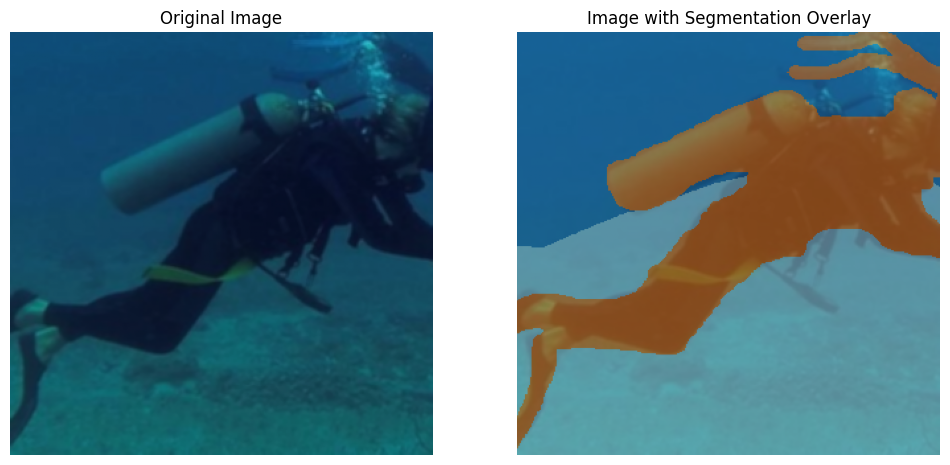

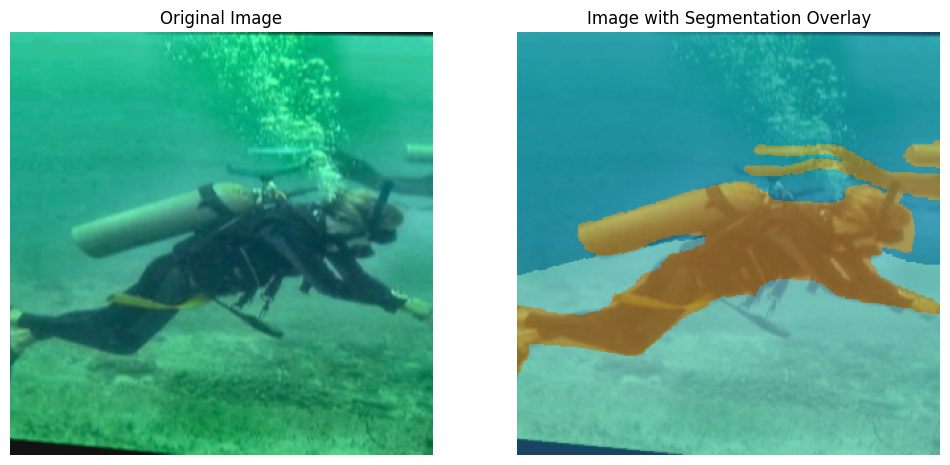

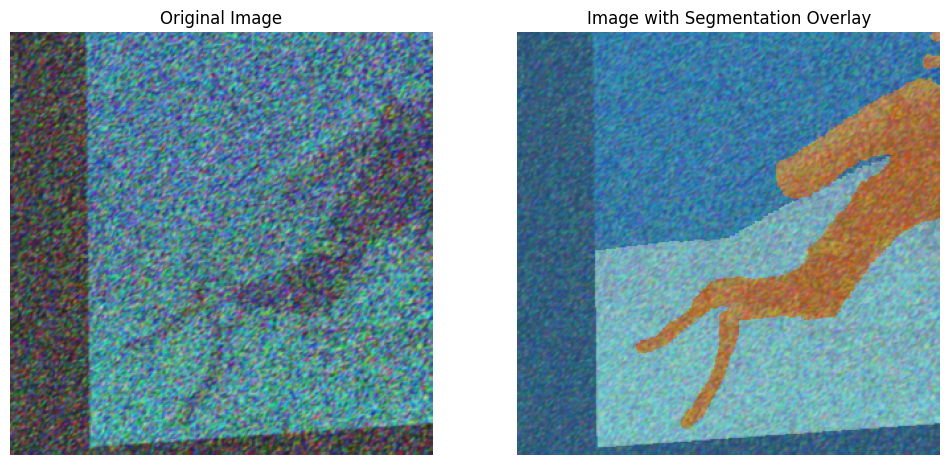

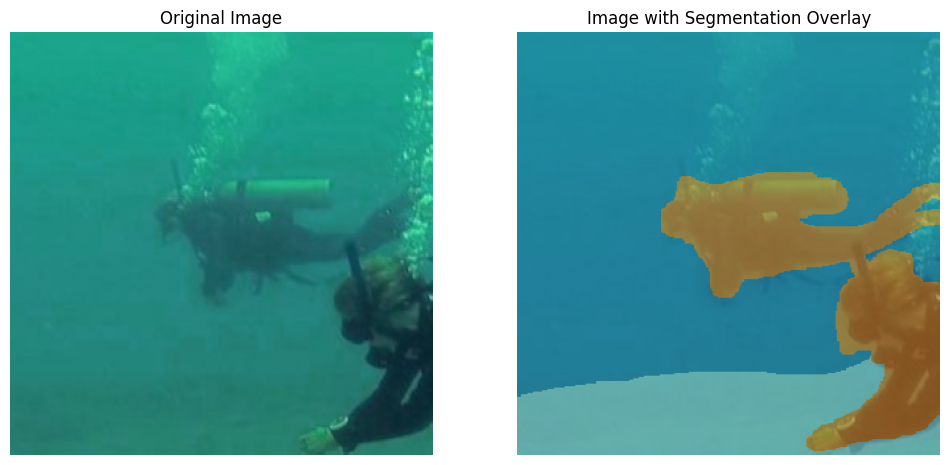

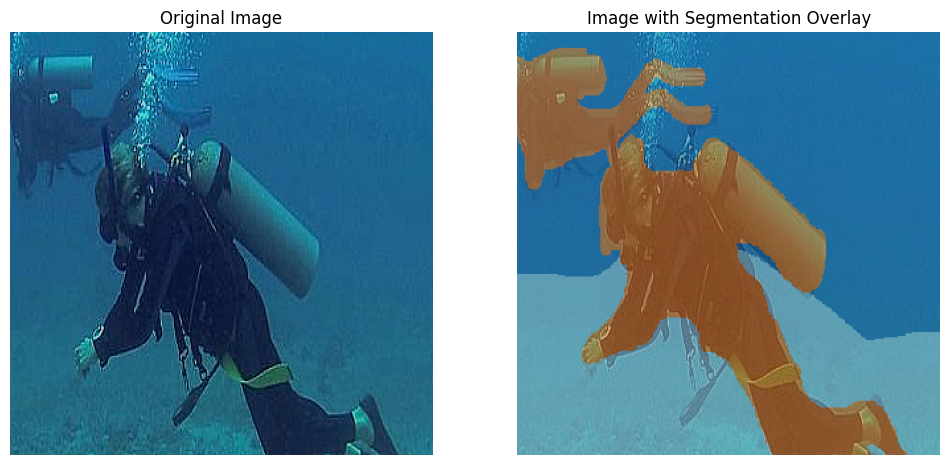

In [11]:
augmented_train_dataset = CustomDataset(base_path=path, train=True, augmentation=get_training_augmentation())
for _ in range(5):
  image, mask = augmented_train_dataset[43]
  visualize(image,mask)

## 4. Training the model

In this code, a **Dice Loss** and **IoU metric** are used to train and validate a segmentation model. 

The `DiceLoss()` function measures the overlap between predicted and ground truth masks, optimizing the model for improved segmentation accuracy. 

The **IoU (Intersection over Union)** metric is also used to assess model performance by measuring the ratio of the overlap between predicted and actual object areas.

The **optimizer** used here is the **Adam optimizer**, known for its efficiency and self-tuning capabilities. It is configured with a learning rate of 0.0001 and weight decay to prevent overfitting.

A **learning rate scheduler**, **ReduceLROnPlateau**, is used to adjust the learning rate during training. It reduces the learning rate by a factor of 0.5 when the validation loss plateaus for 3 consecutive epochs.

Finally, two custom epochs, `TrainEpoch` and `ValidEpoch`, are set up to handle the training and validation steps. They include the model, loss function, metrics, optimizer, and device configuration, with verbosity enabled for detailed training/validation output.


In [12]:
class UNetWithDropout(smp.Unet):
    def __init__(self, encoder_name, encoder_weights, classes, activation, in_channels=3, dropout_prob=0.5):
        super().__init__(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            classes=classes,
            activation=activation,
            in_channels=in_channels
        )
        self.dropout = nn.Dropout2d(p=dropout_prob)  # Dropout layer

    def forward(self, x):
        """Forward method with dropout added to the encoder and decoder outputs."""
        features = self.encoder(x)
        features = [self.dropout(feature) for feature in features]  # Apply dropout after each encoder layer
        decoder_output = self.decoder(*features)  # Decode features
        masks = self.segmentation_head(decoder_output)  # Generate segmentation mask
        return masks

In [13]:
EPOCHS = 50
MODEL_NAME = "Unet-resnet50-ssl"
MODEL_CLASS = UNetWithDropout # smp.FPN
LR = "1e-4"

MODEL_FOLDER = f"./results/{MODEL_NAME}"
create_folder_if_not_exist(MODEL_FOLDER)

index_run = 1
foldernames = [foldername for foldername in os.listdir(MODEL_FOLDER) if os.path.isdir(f"{MODEL_FOLDER}/{foldername}")]
if len(foldernames) > 0:
  last_run = max([int(foldername.split("-")[0]) for foldername in foldernames])
  index_run = last_run+1
  
RESULTS_FOLDER = f"{MODEL_FOLDER}/{index_run}-epochs{EPOCHS}"
create_folder_if_not_exist(RESULTS_FOLDER)

MASKS_FOLDER = f"{RESULTS_FOLDER}/masks"
create_folder_if_not_exist(MASKS_FOLDER)

BEST_MODEL = f'{RESULTS_FOLDER}/best_model.pth'
LAST_MODEL = f'{RESULTS_FOLDER}/last_model.pth'

FILENAME = f"{RESULTS_FOLDER}/training_results_lr={LR}"
FILENAME_TEST = f"{RESULTS_FOLDER}/test_results_lr={LR}"

In [14]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'ssl'
ACTIVATION = 'softmax2d'  # Use sigmoid  if doing one-single-class segmentation
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MODEL_CLASS(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,  # Use 'imagenet' pretrained weights for encoder initialization
    classes=len(CLASSES),  # Number of classes in your dataset
    activation=ACTIVATION,  # Activation function for the output
    in_channels=3,  # Model input channels (1 for gray-scale images, 3 for RGB, etc.)
    dropout_prob=0.3
    # decoder_dropout=0.3
)

# Get preprocessing function for the encoder
preprocessing_fn = get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

print("Running on: ", DEVICE)

Running on:  cuda


### Dataset splitting

The training dataset is split in train and validation with a 80/20 factor.

This is useful to check at every epoch how the model performs with unseen data

In [15]:
dataset = CustomDataset(base_path=path, train=True, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

# Define the length of the training and validation datasets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset into training and validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [16]:
print(f"Dataset length: {len(dataset)}")
print(f"Train dataset length: {train_size}")
print(f"Validation dataset length: {val_size}")

Dataset length: 1525
Train dataset length: 1220
Validation dataset length: 305


In [17]:
# Class pixel counts from your data
pixel_counts = torch.tensor([189688979, 12313599, 11940788, 37353994, 2917692, 186100654, 39309599, 78415339])

# Compute weights inversely proportional to pixel counts
total_pixels = pixel_counts.sum()
class_weights = total_pixels / (pixel_counts * len(pixel_counts))
class_weights += class_weights.mean()
class_weights = class_weights / class_weights.max()  # Normalize weights to the range [0, 1]
print("Normalized Class Weights:", class_weights)

Normalized Class Weights: tensor([0.1881, 0.3708, 0.3769, 0.2398, 1.0000, 0.1883, 0.2366, 0.2061])


In [18]:
class WeightedDiceLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedDiceLoss, self).__init__()
        self.class_weights = class_weights
        self.__name__ = "dice_loss"  # Add this line
        
    def forward(self, outputs, targets):
        dice_loss = 0.0
        for class_idx, weight in enumerate(self.class_weights):
            # Check if the class is present in either targets or outputs
            if targets[:, class_idx].sum() > 0 or outputs[:, class_idx].sum() > 0:
                # Calculate Dice for this class
                intersection = (outputs[:, class_idx] * targets[:, class_idx]).sum()
                union = outputs[:, class_idx].sum() + targets[:, class_idx].sum()
                dice = (2.0 * intersection) / (union + 1e-5)

                # Apply the weight to the loss for this class
                dice_loss += weight * (1 - dice)

        return dice_loss / len(self.class_weights)

class_weights = class_weights.to(DEVICE)  # Move to the correct device

weighted_loss = WeightedDiceLoss(class_weights)

In [19]:
loss = weighted_loss #utils.losses.DiceLoss() 
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001, weight_decay=1e-4),
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)

train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

/home/mike/DeVinci/Machine_Learning_for_CV/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
max_score = 0

train_losses, train_ious = [], []
valid_losses, valid_ious = [], []

for i in range(1, EPOCHS+1):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    scheduler.step(valid_logs['dice_loss'])
    
    train_losses.append(train_logs['dice_loss']) 
    train_ious.append(train_logs['iou_score']) 
    
    valid_losses.append(valid_logs['dice_loss'])
    valid_ious.append(valid_logs['iou_score'])
    
    torch.save(model, LAST_MODEL)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, BEST_MODEL)
        print('Model saved!')

    # if i == 25:
    #     optimizer.param_groups[0]['lr'] = 1e-5
    #     print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 305/305 [00:19<00:00, 15.97it/s, dice_loss - 0.3337, iou_score - 0.08942]
Model saved!

Epoch: 2
valid: 100%|██████████| 305/305 [00:18<00:00, 16.49it/s, dice_loss - 0.3288, iou_score - 0.299] 
Model saved!

Epoch: 3
valid: 100%|██████████| 305/305 [00:19<00:00, 16.02it/s, dice_loss - 0.3232, iou_score - 0.4183]
Model saved!

Epoch: 4
valid: 100%|██████████| 305/305 [00:18<00:00, 16.70it/s, dice_loss - 0.3215, iou_score - 0.403] 

Epoch: 5
valid: 100%|██████████| 305/305 [00:19<00:00, 16.00it/s, dice_loss - 0.3201, iou_score - 0.4389]
Model saved!

Epoch: 6
valid: 100%|██████████| 305/305 [00:19<00:00, 15.74it/s, dice_loss - 0.3201, iou_score - 0.4097]

Epoch: 7
valid: 100%|██████████| 305/305 [00:18<00:00, 16.31it/s, dice_loss - 0.321, iou_score - 0.3827] 

Epoch: 8
valid: 100%|██████████| 305/305 [00:19<00:00, 15.92it/s, dice_loss - 0.3175, iou_score - 0.445] 
Model saved!

Epoch: 9
valid: 100%|██████████| 305/305 [00:18<00:00, 16.22it/s, dice_loss -

In [21]:
with open(f"{FILENAME}.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header row
    writer.writerow(['Train Loss', 'Train IoU', 'Validation Loss', 'Validation IoU'])
    
    # Write data for each epoch
    for epoch in range(len(train_losses)):
        writer.writerow([train_losses[epoch], train_ious[epoch], valid_losses[epoch], valid_ious[epoch]])

print(f"Training results have been saved to {f"{FILENAME}.csv"}")

Training results have been saved to ./results/Unet-resnet50-ssl/2-epochs50/training_results_lr=1e-4.csv


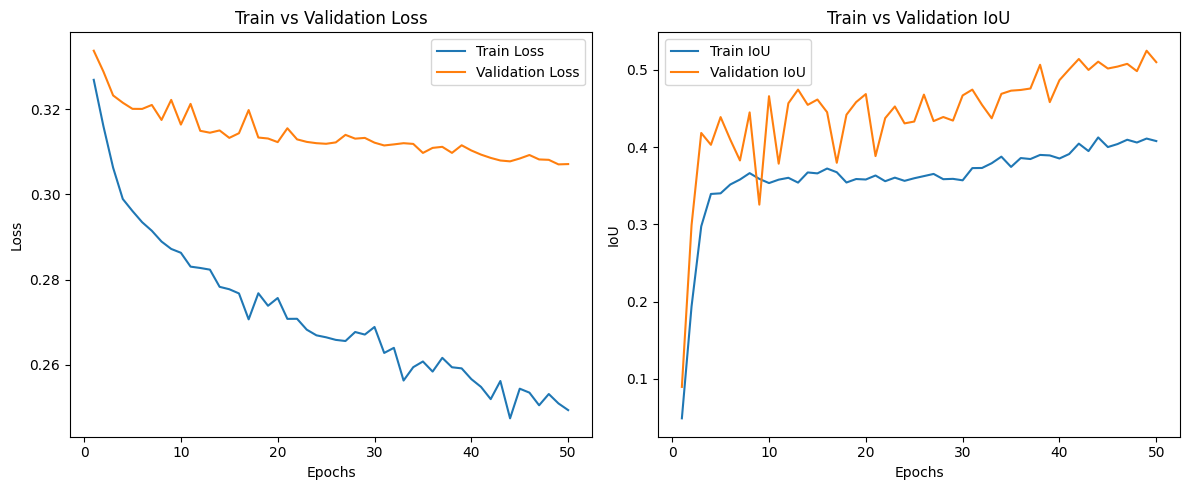

In [22]:
epochs = range(1, EPOCHS + 1)

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, train_ious, label='Train IoU')
plt.plot(epochs, valid_ious, label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Train vs Validation IoU')
plt.legend()

plt.savefig(f"{FILENAME}.png")
plt.tight_layout()
plt.show()

## Validation

Finally the model is tested on the TEST database

In [23]:
best_model = torch.load(BEST_MODEL)

/tmp/ipykernel_183116/1505963342.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(BEST_MODEL)


In [24]:
test_dataset = CustomDataset(base_path=path, train=False, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

test_dataloader = DataLoader(test_dataset)

print(f"Test dataset length: {len(test_dataset)}")

Test dataset length: 110


In [25]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

test_logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 110/110 [00:19<00:00,  5.62it/s, dice_loss - 0.2826, iou_score - 0.6212]


In [26]:
with open(f"{FILENAME_TEST}.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Test Loss', 'Test IoU'])
    writer.writerow([test_logs["dice_loss"], test_logs["iou_score"]])

print(f"Test results have been saved to {f"{FILENAME_TEST}.csv"}")

Test results have been saved to ./results/Unet-resnet50-ssl/2-epochs50/test_results_lr=1e-4.csv
